전력사용량 예측 경진대회

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings("ignore")

# Business Understand

**평가 기준**

|항목|심사기준|점수|
|---|---|---|
|데이터|타당한 데이터 분석 기법 및 기준을 통해 분석했는가?|10|
|시각화|의도를 직관적으로 전달하는 시각화인가? |10|
|코드 품질|코드의 오류 없이 간결한 코드를 작성하였는가? |5|
|분석 방법|문제 해결을 위한 논리적인 구조가 명확한가? |10|
|성능|코드를 통해 전력산출량을 정확히 예측할 수 있는가? |30|
|관점|다른 사람이 생각하지 못한 새로운 관점을 제시하였는가? |10|
|인사이트|전력 융합신서비스 발굴 및 비즈니스 모델 개발 활용에 도움이 될 인사이트를 발굴하였는가? |25|

**논리성의 성능은 참가자가 게재한 코드의 구현 성능을 기준으로 함**

**평가 산식: SMAPE**
- Symmetric Mean Absolute Percentage Error
- MAPE의 경우  Actual 값이 0이거나 작은 경우 MAPE값이 지나치게 커지는 문제 발생
- SMAPE는 이를 개선

In [4]:
from IPython.display import Image
Image(url='https://wikimedia.org/api/rest_v1/media/math/render/svg/d1bfa1853da325fa525c67f48939e9131aad5700',
      width=230
     )

In [5]:
Image(url='https://wikimedia.org/api/rest_v1/media/math/render/svg/9d7003eba8a7ffe2379cd5c232adf78daa3d1edf',
      width=300
     )

In [4]:
def MAE(true, pred): # Mean Absolute Error
    '''
    true: np.array 
    pred: np.array
    '''
    return np.mean(np.abs(true-pred))

def MAPE(true, pred): # Mean Absolute Percentage Error
    '''
    true: np.array 
    pred: np.array
    '''
    return np.mean(np.abs((true-pred)/true))

def SMAPE(true, pred): # Symmetric Mean Absolute Percentage Error
    '''
    true: np.array 
    pred: np.array
    '''
    return np.mean((np.abs(true-pred))/(np.abs(true) + np.abs(pred))) #100은 상수이므로 이번 코드에서는 제외

TRUE_UNDER = np.array([10, 20, 30, 40, 50])
PRED_OVER = np.array([30, 40, 50, 60, 70])
TRUE_OVER = np.array([30, 40, 50, 60, 70])
PRED_UNDER = np.array([10, 20, 30, 40, 50])


print('평균 오차가 20일 때 실제값과 예측값의 대소 관계에 따른 MAE, MAPE 비교 \n')

print('실제값이 예측값 보다 작을 때 (예측값이 과대추정)')
print('MAE:', MAE(TRUE_UNDER, PRED_OVER))
print('MAPE:', MAPE(TRUE_UNDER, PRED_OVER))
print('SMAPE:', SMAPE(TRUE_UNDER, PRED_OVER))


print('\n실제값이 예측값 보다 클 때 (예측값이 과소추정)')
print('MAE:', MAE(TRUE_OVER, PRED_UNDER))
print('MAPE:', MAPE(TRUE_OVER, PRED_UNDER))
print('SMAPE:', SMAPE(TRUE_OVER, PRED_UNDER))

평균 오차가 20일 때 실제값과 예측값의 대소 관계에 따른 MAE, MAPE 비교 

실제값이 예측값 보다 작을 때 (예측값이 과대추정)
MAE: 20.0
MAPE: 0.9133333333333333
SMAPE: 0.29

실제값이 예측값 보다 클 때 (예측값이 과소추정)
MAE: 20.0
MAPE: 0.4371428571428571
SMAPE: 0.29


하지만 **SMAPE는 분모에 예측값 y^i이 들어가서 y^i에 의존적인 특성**을 지니고 있습니다. 예측값이 과소추정할 때 분모가 더 작아지므로 계산되는 오차가 커지는 현상이 발생합니다. 아래 코드를 통해 확인해보겠습니다.

In [5]:
TRUE2 = np.array([40, 50, 60, 70, 80])
PRED2_UNDER = np.array([20, 30, 40, 50, 60])
PRED2_OVER = np.array([60, 70, 80, 90, 100])

print('평균 오차가 20일 때 과소추정, 과대추정에 따른 MAE, SMAPE 비교 \n')

print('과대추정 시')
print('MAE:', MAE(TRUE2, PRED2_OVER))
print('MAPE:', MAPE(TRUE2, PRED2_OVER))
print('SMAPE:', SMAPE(TRUE2, PRED2_OVER))

print('\n과소추정 시')
print('MAE:', MAE(TRUE2, PRED2_UNDER))
print('MAPE:', MAPE(TRUE2, PRED2_UNDER))
print('SMAPE:', SMAPE(TRUE2, PRED2_UNDER))

평균 오차가 20일 때 과소추정, 과대추정에 따른 MAE, SMAPE 비교 

과대추정 시
MAE: 20.0
MAPE: 0.3538095238095238
SMAPE: 0.14912698412698414

과소추정 시
MAE: 20.0
MAPE: 0.3538095238095238
SMAPE: 0.21857142857142856


**외부 데이터 및 사전 학습 모델**
- 평가 데이터 셋 이전 기간 **(2020년 8월 25일 전)** 의 외부 데이터 사용 가능
- 공공 데이터 및 법적 제약이 없는 외부 데이터 허용
- 사전학습 모델의 경우 사전학습에 사용된 데이터를 명시

# Data Understanding

**train.csv:**
- 60개 건물들의 2020년 6월 1일부터 2020년 8월 24일까지의 데이터
- 1시간 단위로 제공
- 전력사용량(kWh) 포함
- shape: (122400, 10)

**test.csv:**
- 60개 건물들의 2020년 8월 25일부터 2020년 8월 31일까지의 데이터
- 3시간 단위로 제공(강수량의 경우 6시간 단위로 제공, 예보데이터)
- 전력사용량(kWh) 미포함
- shape: (10080, 9)

In [10]:
PATH = r'C:\Users\Wyatt\wyatt37\data\energy'

In [11]:
train_col = ['num', 'date_time', 'target', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']
test_col = ['num', 'date_time', 'temp', 'wind', 'humid', 'rain', 'sunny', 'cooler', 'solar']

In [12]:
train = pd.read_csv(PATH + '\\train.csv', encoding='cp949', names=train_col, header=0)
train

,num,date_time,target,temp,wind,humid,rain,sunny,cooler,solar
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [13]:
test = pd.read_csv(PATH + '\\test.csv', encoding='cp949', names=test_col, header=0)
test

,num,date_time,temp,wind,humid,rain,sunny,cooler,solar
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
sub = pd.read_csv(PATH + '\\sample_submission.csv', encoding='cp949')
sub

,num_date_time,answer
0,1 2020-08-25 00,0
1,1 2020-08-25 01,0
2,1 2020-08-25 02,0
3,1 2020-08-25 03,0
4,1 2020-08-25 04,0
...,...,...
10075,60 2020-08-31 19,0
10076,60 2020-08-31 20,0
10077,60 2020-08-31 21,0
10078,60 2020-08-31 22,0


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   num        122400 non-null  int64  
 1   date_time  122400 non-null  object 
 2   target     122400 non-null  float64
 3   temp       122400 non-null  float64
 4   wind       122400 non-null  float64
 5   humid      122400 non-null  float64
 6   rain       122400 non-null  float64
 7   sunny      122400 non-null  float64
 8   cooler     122400 non-null  float64
 9   solar      122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB


In [362]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   num        10080 non-null  int64  
 1   date_time  10080 non-null  object 
 2   temp       3360 non-null   float64
 3   wind       3360 non-null   float64
 4   humid      3360 non-null   float64
 5   rain       1680 non-null   float64
 6   sunny      3360 non-null   float64
 7   cooler     2296 non-null   float64
 8   solar      1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


In [363]:
test.head(10)

,num,date_time,temp,wind,humid,rain,sunny,cooler,solar
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1,2020-08-25 05,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,1,2020-08-25 06,26.1,1.3,83.0,0.0,0.0,NaN,NaN
7,1,2020-08-25 07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1,2020-08-25 08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1,2020-08-25 09,28.8,1.2,77.0,NaN,1.1,NaN,NaN


In [16]:
def make_time(train):
    train['datetime'] = pd.to_datetime(train.date_time)

    train['month'] = train.datetime.dt.month                    # 월(숫자)
    train['day'] = train.datetime.dt.day                        # 일(숫자)
    train['hour'] = train.datetime.dt.hour                      # 시(숫자)
    train['weekday'] = train.datetime.dt.weekday                # 시(숫자)
    train['dayofyear'] = train.datetime.dt.dayofyear            # 연 기준 몇일째(숫자)
    train['weekofyear'] = train.datetime.dt.isocalendar().week  # 연 기준 몇주째(숫자) (=week)
    
    train.drop(['date_time', 'datetime'], axis=1, inplace=True)
    
    train.weekofyear = train.weekofyear.astype(int)
    
    return train

In [17]:
train = make_time(train)
test = make_time(test)

In [366]:
train

,num,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,weekofyear
0,1,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,0,153,23
1,1,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1,0,153,23
2,1,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2,0,153,23
3,1,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3,0,153,23
4,1,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4,0,153,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,8,24,19,0,237,35
122396,60,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,8,24,20,0,237,35
122397,60,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,8,24,21,0,237,35
122398,60,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,8,24,22,0,237,35


test의 rain 값을 중간값으로 채워줄 것이다.

In [18]:
# 앞 뒤 3시간의 예보의 중간값으로 채워줍니다.
for i in range(3, len(test), 6):
    try:
        test.loc[i, 'rain'] = (test.rain[i+3] + test.rain[i-3])/2
    except:
        test.loc[i, 'rain'] = 0

In [19]:
# cooler와 solar를 넣어주겠습니다.
for i in range(1, 61):
    test.loc[test.num == i, 'cooler'] = train.loc[train.num == i, 'cooler'].mean()
    test.loc[test.num == i, 'solar'] = train.loc[train.num == i, 'solar'].mean()

In [20]:
test.isnull().sum()

num              0
temp          6720
wind          6720
humid         6720
rain          6720
sunny         6720
cooler           0
solar            0
month            0
day              0
hour             0
weekday          0
dayofyear        0
weekofyear       0
dtype: int64

In [370]:
test

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,weekofyear
0,1,27.8,1.5,74.0,0.0,0.0,0.0,0.0,8,25,0,1,238,35
1,1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,8,25,1,1,238,35
2,1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,8,25,2,1,238,35
3,1,27.3,1.1,78.0,0.0,0.0,0.0,0.0,8,25,3,1,238,35
4,1,NaN,NaN,NaN,NaN,NaN,0.0,0.0,8,25,4,1,238,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,NaN,NaN,NaN,NaN,NaN,1.0,1.0,8,31,19,0,244,36
10076,60,NaN,NaN,NaN,NaN,NaN,1.0,1.0,8,31,20,0,244,36
10077,60,27.9,4.1,68.0,0.0,0.0,1.0,1.0,8,31,21,0,244,36
10078,60,NaN,NaN,NaN,NaN,NaN,1.0,1.0,8,31,22,0,244,36


## EDA

<AxesSubplot:xlabel='day', ylabel='target'>

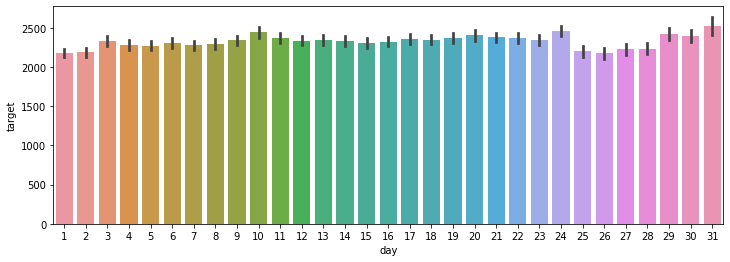

In [145]:
plt.figure(figsize=(12, 4))
sns.barplot(data=train, x='day', y='target')

<AxesSubplot:xlabel='dayofyear', ylabel='target'>

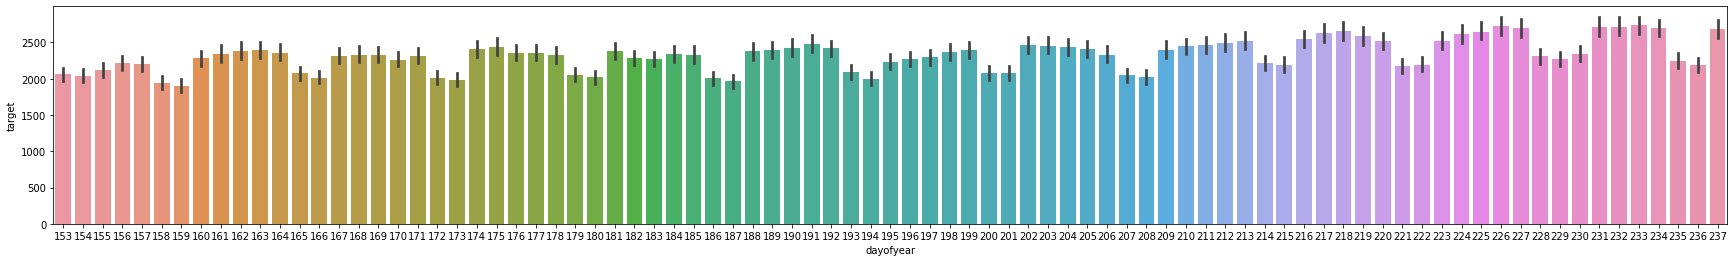

In [148]:
plt.figure(figsize=(30, 4))
sns.barplot(data=train, x='dayofyear', y='target')

<AxesSubplot:xlabel='hour', ylabel='target'>

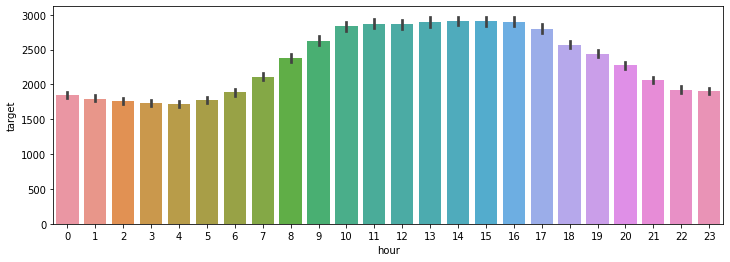

In [136]:
plt.figure(figsize=(12, 4))
sns.barplot(data=train, x='hour', y='target')

<AxesSubplot:xlabel='num', ylabel='target'>

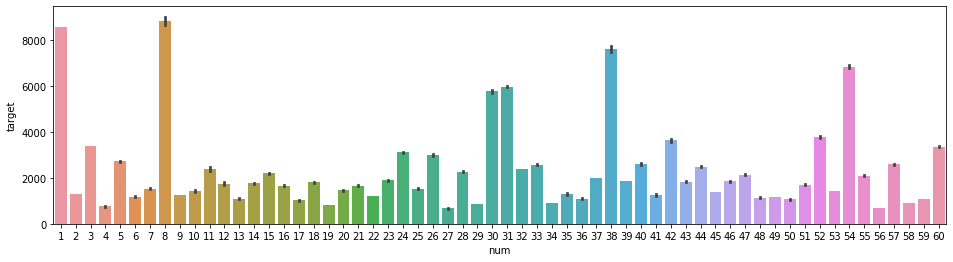

In [149]:
plt.figure(figsize=(16, 4))
sns.barplot(data=train, x='num', y='target')

<AxesSubplot:xlabel='weekday', ylabel='target'>

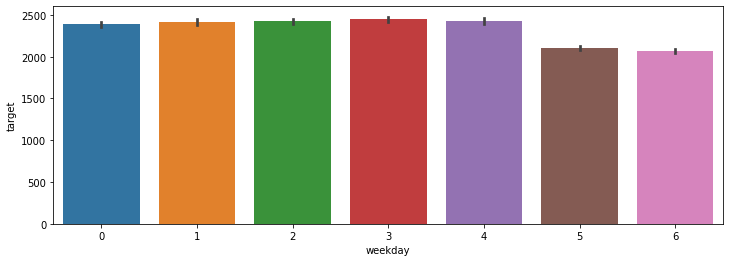

In [138]:
plt.figure(figsize=(12, 4))
sns.barplot(data=train, x='weekday', y='target')

<AxesSubplot:xlabel='month', ylabel='target'>

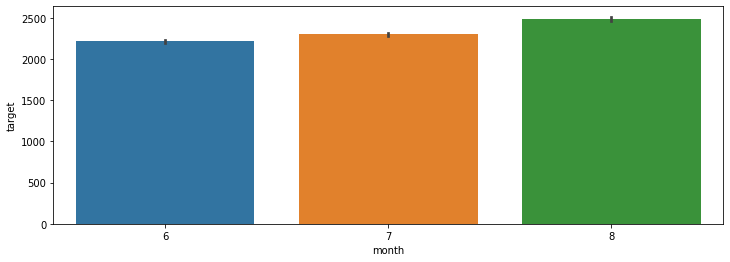

In [139]:
plt.figure(figsize=(12, 4))
sns.barplot(data=train, x='month', y='target')

<AxesSubplot:xlabel='weekofyear', ylabel='target'>

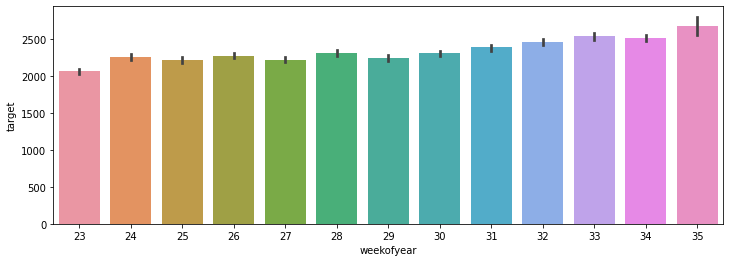

In [140]:
plt.figure(figsize=(12, 4))
sns.barplot(data=train, x='weekofyear', y='target')

### dayofyear

<AxesSubplot:xlabel='dayofyear', ylabel='target'>

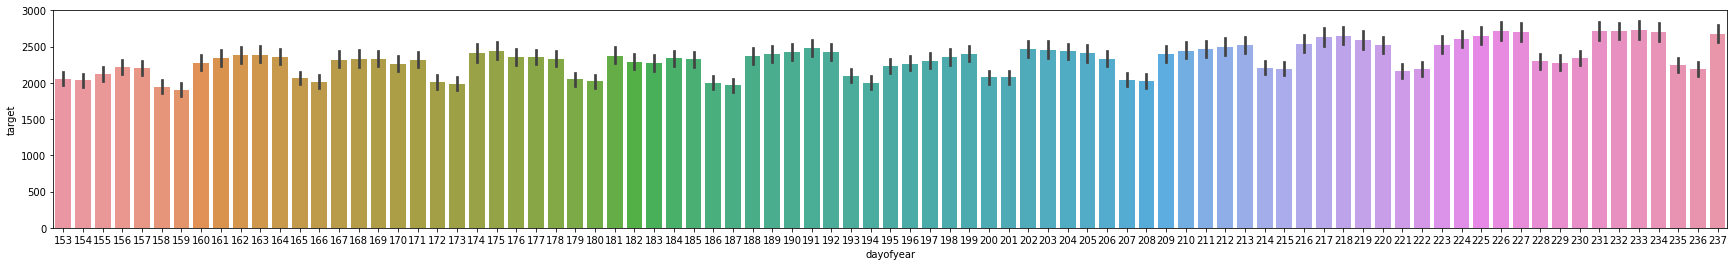

In [157]:
plt.figure(figsize=(30, 4))
sns.barplot(data=train, x='dayofyear', y='target')

<AxesSubplot:xlabel='dayofyear', ylabel='temp'>

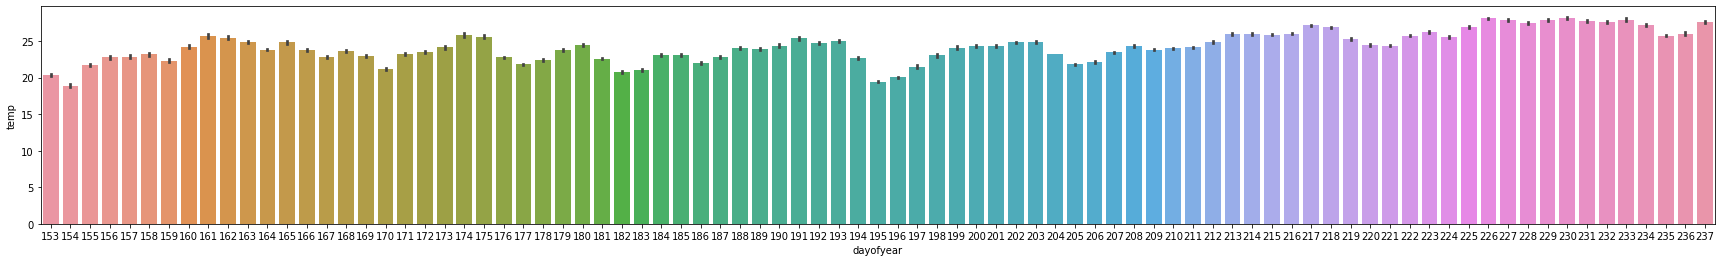

In [151]:
plt.figure(figsize=(30, 4))
sns.barplot(data=train, x='dayofyear', y='temp')

<AxesSubplot:xlabel='dayofyear', ylabel='wind'>

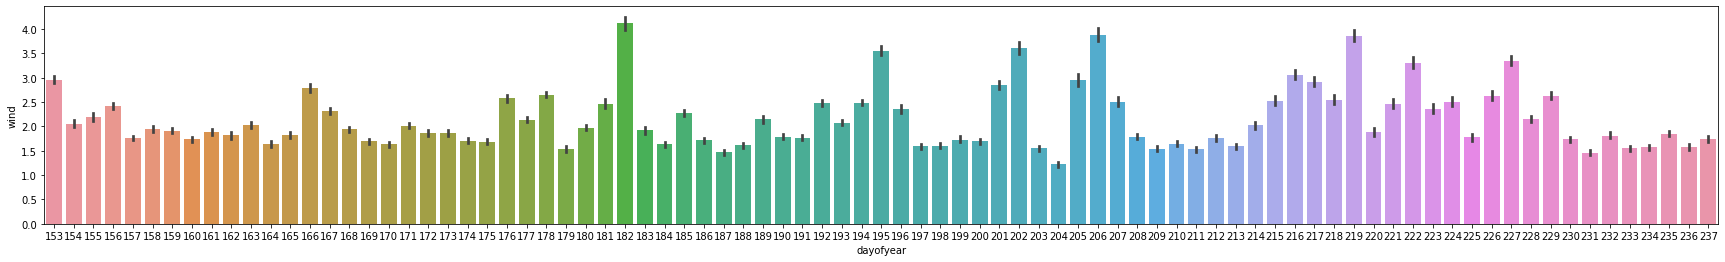

In [152]:
plt.figure(figsize=(30, 4))
sns.barplot(data=train, x='dayofyear', y='wind')

<AxesSubplot:xlabel='dayofyear', ylabel='humid'>

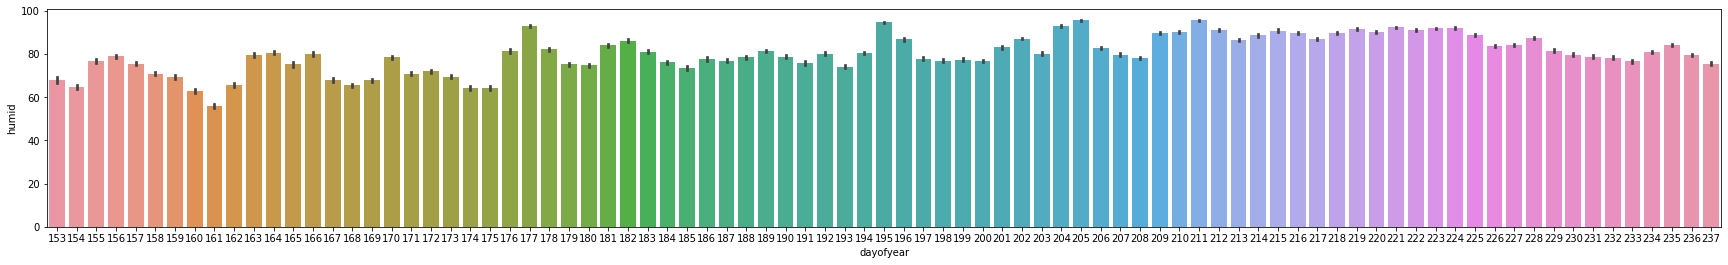

In [153]:
plt.figure(figsize=(30, 4))
sns.barplot(data=train, x='dayofyear', y='humid')

<AxesSubplot:xlabel='dayofyear', ylabel='sunny'>

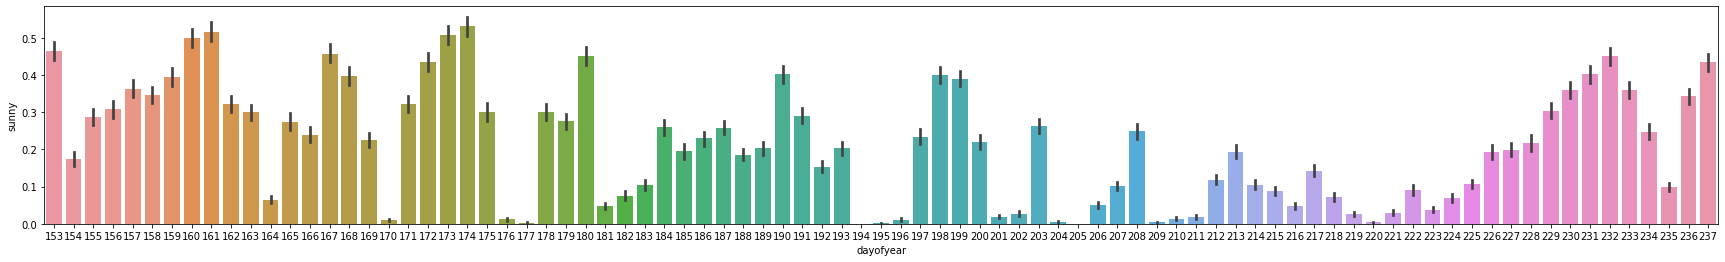

In [158]:
plt.figure(figsize=(30, 4))
sns.barplot(data=train, x='dayofyear', y='sunny')

In [161]:
train

,num,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,weekofyear
0,1,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,0,153,23
1,1,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1,0,153,23
2,1,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2,0,153,23
3,1,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3,0,153,23
4,1,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4,0,153,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,8,24,19,0,237,35
122396,60,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,8,24,20,0,237,35
122397,60,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,8,24,21,0,237,35
122398,60,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,8,24,22,0,237,35


### target

In [216]:
train.loc[train.num == 1].groupby(['weekday', 'hour'])['target'].mean().unstack().T

weekday,0,1,2,3,4,5,6
hour,,,,,,,
0,8528.627077,8505.972,8518.392,8548.686,8560.674,8567.802,8553.438
1,8513.723077,8442.414,8503.380,8525.790,8539.398,8555.760,8540.046
2,8496.625846,8475.948,8485.884,8509.536,8524.980,8542.854,8528.598
3,8480.076923,8444.844,8474.814,8499.060,8507.646,8536.806,8511.048
4,8472.051692,8425.242,8458.236,8484.264,8493.390,8525.412,8498.682
5,8444.088000,8394.138,8435.124,8472.654,8471.034,8494.092,8472.762
6,8440.150154,8392.842,8429.400,8464.446,8465.634,8475.894,8457.750
7,8477.136000,8436.798,8459.100,8487.774,8495.172,8494.578,8476.920
8,8493.934154,8454.240,8479.890,8505.432,8517.798,8497.440,8469.306


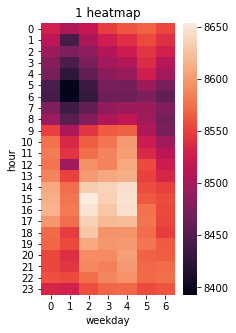

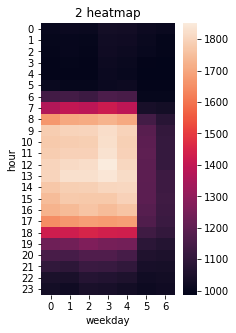

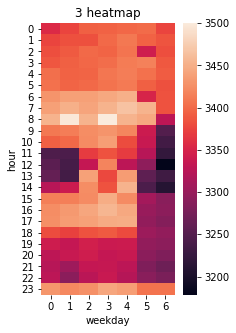

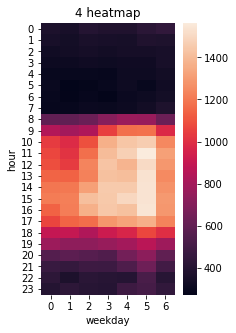

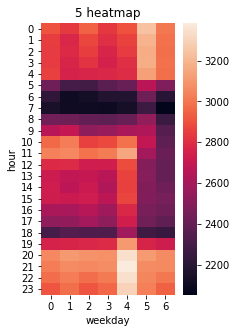

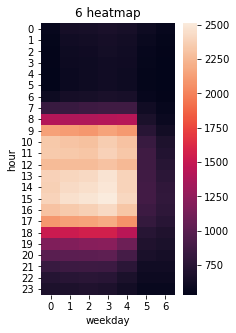

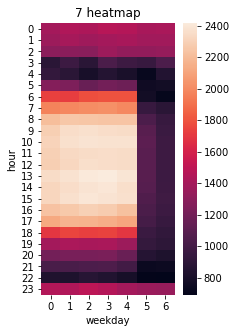

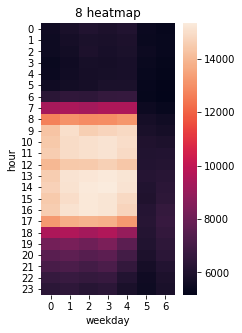

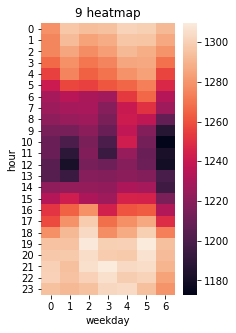

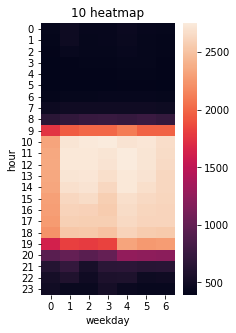

In [22]:
for i in range(1, 11):
    plt.figure(figsize=(3, 5))
    sns.heatmap(train.loc[train.num == i].groupby(['weekday', 'hour'])['target'].mean().unstack().T)
    plt.title("{} heatmap".format(i))
    plt.show()

건물마다 명확히 패턴이 다르게 나타난다.

### Clustering

60개의 빌딩을 클러스터링 할 생각이다. 본 데이터는 빌딩에 대한 데이터는 전혀 가지고 있지 않다. 오히려 기상 데이터만을 가지고 있다. 그렇다는 것은 target을 통해서 빌딩을 분석하고, 빌딩에 맞게 예측을 해야 한다. 그러나 빌딩별로 모델을 만들게 되면 모델이 너무 많아지고, 데이터가 줄어들게 된다. 즉, 가장 합리적인 방법은 군집화를 시켜서 그룹별로 모델을 만들고 예측하는 것이다.

군집화를 위해 몇 가지 방법을 적용해보려고 한다.
- 가장 간단한 k-means, DBSCAN
- 계층적 군집화
- 가우시안 믹스쳐 모델
- SOM(Self-Organizing-Map)

In [28]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

군집화를 위한 데이터셋을 만들어줘야 하는데, 우리가 구별하려는 패턴은 시간에 따른 전력사용량이다. 그렇기 때문에 건물 넘버를 index 축으로 놓고, column을 만들어주어야 한다.

컬럼이 너무 많으면 문제가 생긴다. 일별 평균, 일별 분산, 시간별 평균, 시간별 분산

In [29]:
weekday_mean = (
    train.groupby(['num', 'weekday'])['target'].mean()
    .reset_index()
    .pivot('num', 'weekday', 'target')
    .reset_index()
)

In [30]:
weekday_std = (
    train.groupby(['num', 'weekday'])['target'].std()
    .reset_index()
    .pivot('num', 'weekday', 'target')
    .reset_index()
    .drop('num', axis=1)
)

In [31]:
hour_mean = (
    train.groupby(['num', 'hour'])['target'].mean()
    .reset_index()
    .pivot('num', 'hour', 'target')
    .reset_index()
    .drop('num', axis=1)
)

In [32]:
hour_std = (
    train.groupby(['num', 'hour'])['target'].std()
    .reset_index()
    .pivot('num', 'hour', 'target')
    .reset_index()
    .drop('num', axis=1)
)

In [33]:
cl_df = pd.concat([weekday_mean, hour_mean, weekday_std, hour_std], axis=1)

In [34]:
columns = (
    ['num']
    + ['day_mean_' + str(i) for i in range(7)]
    + ['hour_mean_' + str(i) for i in range(24)]
    + ['day_std_' + str(i) for i in range(7)]
    + ['hour_std_' + str(i) for i in range(24)]
)

In [35]:
cl_df.columns = columns
cl_df

,num,day_mean_0,day_mean_1,day_mean_2,day_mean_3,day_mean_4,day_mean_5,day_mean_6,hour_mean_0,hour_mean_1,...,hour_std_14,hour_std_15,hour_std_16,hour_std_17,hour_std_18,hour_std_19,hour_std_20,hour_std_21,hour_std_22,hour_std_23
0,1,8541.545538,8507.432250,8551.757250,8561.101500,8570.308500,8543.843125,8527.070250,8540.373176,8517.174776,...,128.852233,127.814960,125.200218,120.670025,115.810792,112.408351,114.284290,112.657414,113.749026,112.773624
1,2,1373.904346,1383.035625,1389.466125,1402.357500,1390.788000,1093.347000,1060.336125,1016.083059,1006.713741,...,313.679786,302.298833,291.093720,256.222645,170.511835,97.109591,63.720834,51.013009,41.588007,41.014307
2,3,3371.143240,3371.748507,3398.873622,3406.395846,3402.517822,3340.100728,3308.713665,3383.537538,3389.803091,...,186.943832,101.903661,103.021070,101.394662,85.960475,85.250723,87.424569,86.669986,83.885558,238.229455
3,4,684.863829,678.183456,727.799464,794.561580,825.467101,877.090723,766.609781,390.832518,358.194071,...,406.270281,410.646249,398.755187,329.343214,256.087377,221.727136,181.600022,183.255378,150.510579,94.225673
4,5,2720.551846,2703.939000,2698.137000,2685.795000,2838.414000,2744.958000,2609.269500,2950.931012,2904.290259,...,310.985965,330.404338,304.295721,286.853413,276.411275,339.203786,275.458769,281.225054,286.867147,283.665384
5,6,1360.713462,1387.191562,1397.536875,1420.080000,1363.089375,700.644375,644.938125,625.307294,603.472235,...,766.357827,773.147366,735.213173,647.787103,388.221789,240.184197,164.211297,106.516147,73.299359,57.261613
6,7,1713.551068,1739.770085,1742.421445,1754.745388,1725.808552,1020.232246,977.905313,1431.963443,1386.630754,...,626.266044,632.309526,592.661185,552.309018,364.056180,229.896088,174.235660,135.743938,86.112893,80.759995
7,8,9802.109005,10089.995499,10092.764069,10174.166041,9950.387163,5781.046741,5890.684579,5751.969625,5683.227246,...,4251.028513,4172.036741,4102.845116,3547.556411,1623.231074,1057.040477,911.033992,827.492877,697.240612,598.524857
8,9,1251.729692,1255.232942,1261.113000,1254.965625,1266.738375,1266.147000,1242.697125,1293.354635,1288.044847,...,73.216961,71.088390,61.731906,53.833656,44.679836,37.986519,36.169944,35.470301,38.589295,32.996885
9,10,1280.171886,1443.655199,1432.642765,1435.489290,1494.744877,1466.970188,1448.723625,439.568894,433.797882,...,355.021351,343.559527,333.468761,334.120463,331.401868,362.652646,177.581778,211.307912,216.165633,78.426512


In [36]:
(cl_df.iloc[0, 32:39] - cl_df.iloc[0, 32:39].mean()) / cl_df.iloc[0, 32:39].std()

day_std_0    1.012965
day_std_1    1.560854
day_std_2    0.363704
day_std_3   -0.382260
day_std_4   -0.621158
day_std_5   -1.005863
day_std_6   -0.928243
Name: 0, dtype: float64

In [37]:
for i in range(len(cl_df)):
    cl_df.iloc[i, 1:8] = (cl_df.iloc[i, 1:8] - cl_df.iloc[i, 1:8].mean()) / cl_df.iloc[i, 1:8].std()
    cl_df.iloc[i, 8:32] = (cl_df.iloc[i, 8:32] - cl_df.iloc[i, 8:32].mean()) / cl_df.iloc[i, 8:32].std()
    cl_df.iloc[i, 32:39] = (cl_df.iloc[i, 32:39] - cl_df.iloc[i, 32:39].mean()) / cl_df.iloc[i, 32:39].std()
    cl_df.iloc[i, 39:] = (cl_df.iloc[i, 39:] - cl_df.iloc[i, 39:].mean()) / cl_df.iloc[i, 39:].std()

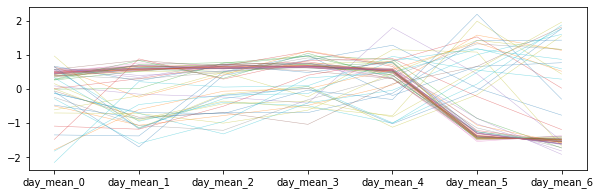

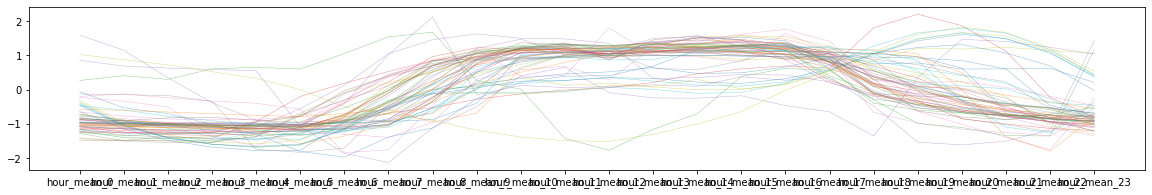

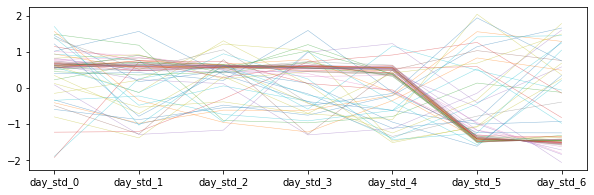

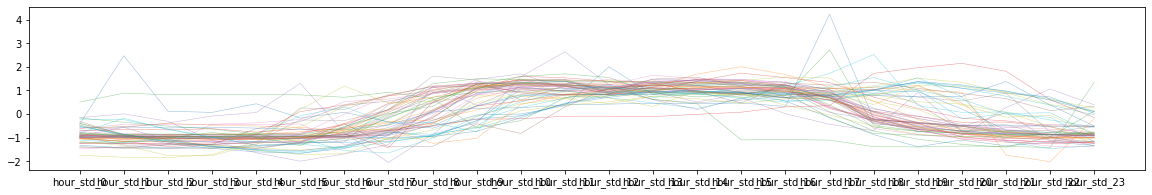

In [38]:
# visualization
fig = plt.figure(figsize = (10,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 1:8], alpha = 0.5, linewidth = 0.5)
    
fig = plt.figure(figsize = (20,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 8:32], alpha = 0.5, linewidth = 0.5)
    
fig = plt.figure(figsize = (10,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 32:39], alpha = 0.5, linewidth = 0.5)
    
fig = plt.figure(figsize = (20,3))
for i in range(len(cl_df)):
    plt.plot(cl_df.iloc[i, 39:], alpha = 0.5, linewidth = 0.5)

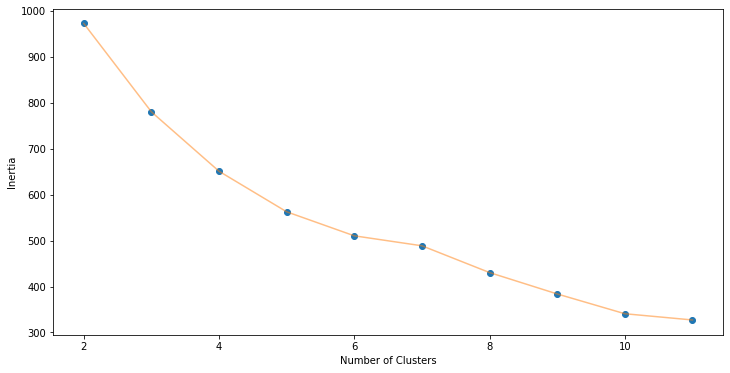

In [39]:
# elbow method를 통해 군집의 개수 결정
def change_n_clusters(n_clusters, data):
    sum_of_squared_distance = []
    for n_cluster in n_clusters:
        kmeans = KMeans(n_clusters=n_cluster)
        kmeans.fit(data)
        sum_of_squared_distance.append(kmeans.inertia_)
        
    plt.figure(1 , figsize = (12, 6))
    plt.plot(n_clusters , sum_of_squared_distance , 'o')
    plt.plot(n_clusters , sum_of_squared_distance , '-' , alpha = 0.5)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')

change_n_clusters([2,3,4,5,6,7,8,9,10,11], cl_df.iloc[:,1:])

In [40]:
linked = linkage(cl_df, 'ward')

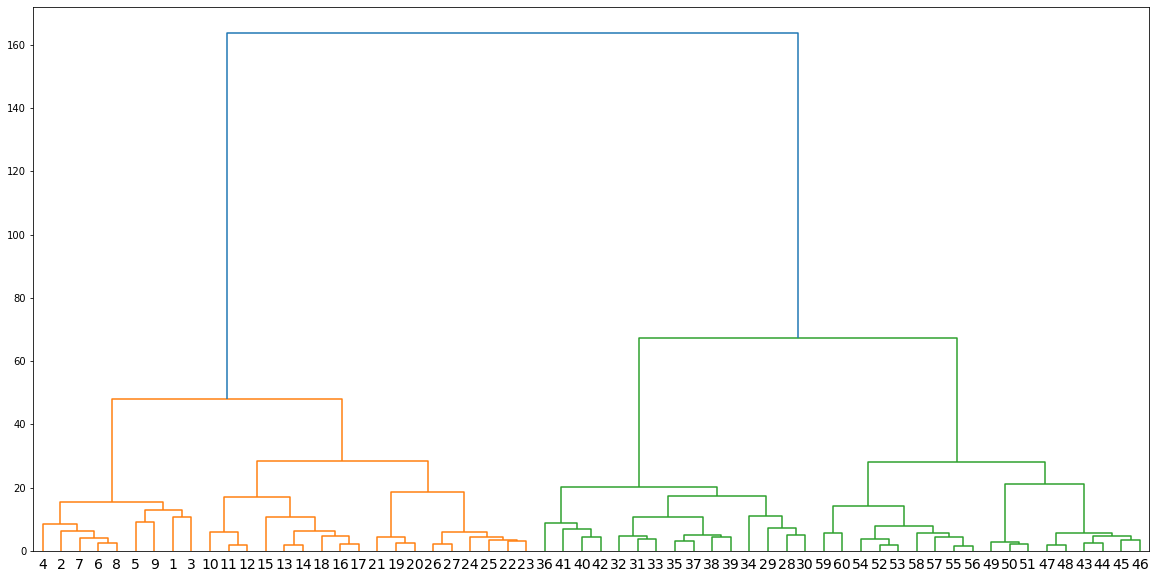

In [41]:
labelList = range(1, 61)

plt.figure(figsize=(20, 10))
dendrogram(linked,
           orientation='top',
           labels=labelList,
           distance_sort='descending',
           show_leaf_counts=True)
plt.xticks(fontsize=14, rotation=0)
plt.show()

In [42]:
model = KMeans(n_clusters = 4, random_state = 42)
pred = model.fit_predict(cl_df.iloc[:, 1:])

In [43]:
cl_df['km_cluster'] = pred

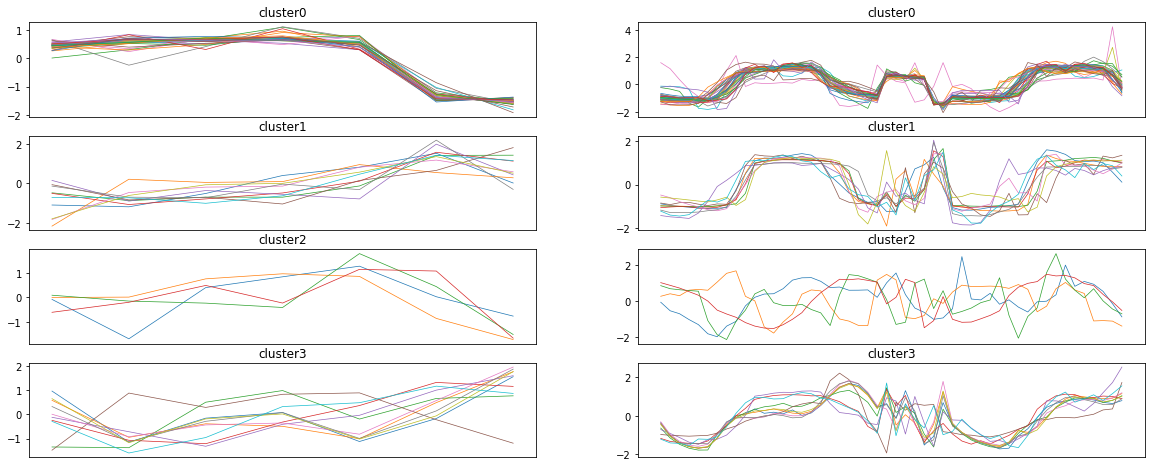

In [44]:
# visualizing result of kmeans clustering
n_c = len(np.unique(cl_df.km_cluster)) 

fig = plt.figure(figsize = (20,8))
for c in range(n_c):
    temp = cl_df[cl_df.km_cluster == c]
    plt.subplot(n_c,2,2*c+1)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,1:8], linewidth=0.7, )
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])
    plt.subplot(n_c,2,2*c+2)
    for i in range(len(temp)):
        plt.plot(temp.iloc[i,8:-6], linewidth=0.7)
        plt.title(f'cluster{c}')
        plt.xlabel('')
        plt.xticks([])

In [45]:
train_cl = pd.merge(train, cl_df[['num', 'km_cluster']], how='left', on='num')

In [46]:
train_cl

,num,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,weekofyear,km_cluster
0,1,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,0,153,23,2
1,1,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1,0,153,23,2
2,1,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2,0,153,23,2
3,1,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3,0,153,23,2
4,1,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4,0,153,23,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,8,24,19,0,237,35,3
122396,60,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,8,24,20,0,237,35,3
122397,60,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,8,24,21,0,237,35,3
122398,60,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,8,24,22,0,237,35,3


어떻게 모델을 설계할 것인가?

- 00시의 데이터를 가지고 00시와, 01시와 02시의 전력 사용량을 예측하는 구조
- 00시와 03시의 데이터를 가지고 사이값을 채워놓고 전력 사용량을 예측하는 구조


- 군집화된 빌딩들 별로 모델링(그래도 데이터가 되니 lgbm으로 가자.)
- 빌딩별로 모델링(데이터가 많지 않으니 랜포로 돌리는 게 나을 것 같다.)

2 X 2 = 4가지의 모델링이 나온다.

In [47]:
triple_test = test.dropna()
triple_test.head()

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,weekofyear
0,1,27.8,1.5,74.0,0.0,0.0,0.0,0.0,8,25,0,1,238,35
1,1,27.6,1.4,75.3,0.0,0.0,0.0,0.0,8,25,1,1,238,35
2,1,27.5,1.2,76.7,0.0,0.0,0.0,0.0,8,25,2,1,238,35
3,1,27.3,1.1,78.0,0.0,0.0,0.0,0.0,8,25,3,1,238,35
4,1,26.9,1.2,79.7,0.0,0.0,0.0,0.0,8,25,4,1,238,35


In [48]:
test[['temp', 'wind', 'humid', 'rain', 'sunny']] = test[['temp', 'wind', 'humid', 'rain', 'sunny']].interpolate(method='values').round(1)

In [49]:
test

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,weekofyear
0,1,27.8,1.5,74.0,0.0,0.0,0.0,0.0,8,25,0,1,238,35
1,1,27.6,1.4,75.3,0.0,0.0,0.0,0.0,8,25,1,1,238,35
2,1,27.5,1.2,76.7,0.0,0.0,0.0,0.0,8,25,2,1,238,35
3,1,27.3,1.1,78.0,0.0,0.0,0.0,0.0,8,25,3,1,238,35
4,1,26.9,1.2,79.7,0.0,0.0,0.0,0.0,8,25,4,1,238,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,28.6,3.6,66.0,0.0,0.5,1.0,1.0,8,31,19,0,244,36
10076,60,28.3,3.8,67.0,0.0,0.3,1.0,1.0,8,31,20,0,244,36
10077,60,27.9,4.1,68.0,0.0,0.0,1.0,1.0,8,31,21,0,244,36
10078,60,27.9,4.1,68.0,0.0,0.0,1.0,1.0,8,31,22,0,244,36


### 빌딩별 모델 X 00시로 01, 02시까지 예측하기(랜포)

In [24]:
from sklearn.ensemble import RandomForestRegressor

빌딩별로 전처리를 따로 진행해야 합니다. 다른 빌딩 데이터가 들어갑니다.

In [25]:
for i in range(1, 61):
    # 빌딩별로 데이터셋을 만듭니다.
    globals()['train_building_{}'.format(i)] = train.loc[train.num == i, :]
    
    # target_1을 만들어줍니다.
    globals()['train_building_{}'.format(i)]['target_1'] = (
        globals()['train_building_{}'.format(i)].target.shift(-1))
    
    # target_2를 만들어줍니다.
    globals()['train_building_{}'.format(i)]['target_2'] = (
        globals()['train_building_{}'.format(i)].target.shift(-2))
    
    # na를 버려줍니다.
    globals()['train_building_{}'.format(i)].dropna(inplace=True)
    
    # y 값을 만들어줍니다.
    globals()['train_building_{}_y1'.format(i)] = globals()['train_building_{}'.format(i)].target
    globals()['train_building_{}_y2'.format(i)] = globals()['train_building_{}'.format(i)].target_1
    globals()['train_building_{}_y3'.format(i)] = globals()['train_building_{}'.format(i)].target_2
    
    # target 값을 버려줍니다.
    globals()['train_building_{}'.format(i)].drop(['target', 'target_1', 'target_2'],
                                                  axis=1, inplace=True)

In [26]:
train_building_1.shape, train_building_1_y1.shape

((2038, 14), (2038,))

#### Model_01

In [196]:
pred_01 = []
for i in tqdm(range(1, 61)):
    test_x = triple_test.loc[triple_test.num == i, :]
    
    rf = RandomForestRegressor(random_state=42)
    rf.fit(globals()['train_building_{}'.format(i)], globals()['train_building_{}_y1'.format(i)])
    pred = rf.predict(test_x)
    pred_01.append(pred)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:37<00:00,  1.62it/s]


#### Model_02

In [198]:
pred_02 = []
for i in tqdm(range(1, 61)):
    test_x = triple_test.loc[triple_test.num == i, :]
    
    rf = RandomForestRegressor(random_state=42)
    rf.fit(globals()['train_building_{}'.format(i)], globals()['train_building_{}_y2'.format(i)])
    pred = rf.predict(test_x)
    pred_02.append(pred)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:36<00:00,  1.62it/s]


#### Model_03

In [199]:
pred_03 = []
for i in tqdm(range(1, 61)):
    test_x = triple_test.loc[triple_test.num == i, :]
    
    rf = RandomForestRegressor(random_state=42)
    rf.fit(globals()['train_building_{}'.format(i)], globals()['train_building_{}_y3'.format(i)])
    pred = rf.predict(test_x)
    pred_03.append(pred)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:37<00:00,  1.62it/s]


In [211]:
final_pred = []
for i in range(60):
    for j in range(56):
        final_pred.append(pred_01[i][j])
        final_pred.append(pred_02[i][j])
        final_pred.append(pred_03[i][j])

In [215]:
sub.answer = final_pred

In [216]:
sub.to_csv('submission/210603_rf-vanila_each-buildingsXeach-hours.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8670.16872
1,1 2020-08-25 01,8674.01136
2,1 2020-08-25 02,8671.21200
3,1 2020-08-25 03,8657.38368
4,1 2020-08-25 04,8668.85328
...,...,...
10075,60 2020-08-31 19,4209.19632
10076,60 2020-08-31 20,3994.85952
10077,60 2020-08-31 21,3845.42208
10078,60 2020-08-31 22,3544.98336


- Base: 6.89369
- Score: 6.74348

### 빌딩별 모델 X 채워진 데이터로 예측하기(랜포)

In [234]:
for i in range(1, 61):
    # 빌딩별로 train_x을 만듭니다.
    globals()['train_building_{}'.format(i)] = train.loc[train.num == i, ~train.columns.isin(['target'])]
    # 빌딩별로 train_y 를 만듭니다.
    globals()['train_building_{}_y'.format(i)] = train.loc[train.num == i, 'target']
    # 빌딩별로 test_x 를 만듭니다.
    globals()['test_building_{}'.format(i)] = test.loc[test.num == i, :]

In [236]:
train_building_60.shape, train_building_60_y.shape, test_building_60.shape

((2040, 14), (2040,), (168, 14))

In [242]:
preds = []
for i in tqdm(range(1, 61)):
    rf = RandomForestRegressor(random_state=42)
    rf.fit(globals()['train_building_{}'.format(i)], globals()['train_building_{}_y'.format(i)])
    pred = rf.predict(globals()['test_building_{}'.format(i)])
    preds.append(pred.tolist())

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:37<00:00,  1.60it/s]


In [244]:
preds = sum(preds, [])

In [245]:
sub.answer = preds

In [246]:
sub.to_csv('submission/210603_rf-vanila_each-buildingsXfilled-hours.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8671.32216
1,1 2020-08-25 01,8669.05416
2,1 2020-08-25 02,8665.67808
3,1 2020-08-25 03,8658.78336
4,1 2020-08-25 04,8653.86504
...,...,...
10075,60 2020-08-31 19,4069.26720
10076,60 2020-08-31 20,4009.73328
10077,60 2020-08-31 21,3812.41728
10078,60 2020-08-31 22,3517.85808


- Base: 6.89369
- ex_Score: 6.74348
- Score: 6.65005

In [247]:
train_building_60

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,weekofyear
120360,60,17.1,2.6,94.0,0.1,0.0,1.0,1.0,6,1,0,0,153,23
120361,60,17.0,5.7,94.0,0.0,0.0,1.0,1.0,6,1,1,0,153,23
120362,60,16.4,5.4,95.0,0.0,0.0,1.0,1.0,6,1,2,0,153,23
120363,60,16.4,3.9,96.0,0.0,0.0,1.0,1.0,6,1,3,0,153,23
120364,60,16.3,5.3,96.0,0.0,0.0,1.0,1.0,6,1,4,0,153,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,27.8,2.3,68.0,0.0,0.7,1.0,1.0,8,24,19,0,237,35
122396,60,27.3,1.2,71.0,0.0,0.0,1.0,1.0,8,24,20,0,237,35
122397,60,27.3,1.8,71.0,0.0,0.0,1.0,1.0,8,24,21,0,237,35
122398,60,27.1,1.8,74.0,0.0,0.0,1.0,1.0,8,24,22,0,237,35


빌딩별로 학습을 시킬 때는 필요없는 num, cooler, solar 를 지워야할 것 같다. 여기서는 동일 값이라 필요가 없다.

### 군집별 모델 X 채워진 데이터로 예측하기(LGBM)

In [51]:
train_cl.km_cluster.value_counts()

0    73440
1    20400
3    20400
2     8160
Name: km_cluster, dtype: int64

In [52]:
train_cl

,num,target,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,weekofyear,km_cluster
0,1,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0,6,1,0,0,153,23,2
1,1,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0,6,1,1,0,153,23,2
2,1,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0,6,1,2,0,153,23,2
3,1,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0,6,1,3,0,153,23,2
4,1,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0,6,1,4,0,153,23,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,60,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0,8,24,19,0,237,35,3
122396,60,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0,8,24,20,0,237,35,3
122397,60,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0,8,24,21,0,237,35,3
122398,60,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0,8,24,22,0,237,35,3


In [53]:
test_cl = test.copy()

In [54]:
# cooler와 solar를 넣어주겠습니다.
for i in range(1, 61):
    test_cl.loc[test_cl.num == i, 'km_cluster'] = (
        train_cl.loc[train_cl.num == i, 'km_cluster'].max()
    )

In [55]:
test_cl

,num,temp,wind,humid,rain,sunny,cooler,solar,month,day,hour,weekday,dayofyear,weekofyear,km_cluster
0,1,27.8,1.5,74.0,0.0,0.0,0.0,0.0,8,25,0,1,238,35,2.0
1,1,27.6,1.4,75.3,0.0,0.0,0.0,0.0,8,25,1,1,238,35,2.0
2,1,27.5,1.2,76.7,0.0,0.0,0.0,0.0,8,25,2,1,238,35,2.0
3,1,27.3,1.1,78.0,0.0,0.0,0.0,0.0,8,25,3,1,238,35,2.0
4,1,26.9,1.2,79.7,0.0,0.0,0.0,0.0,8,25,4,1,238,35,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10075,60,28.6,3.6,66.0,0.0,0.5,1.0,1.0,8,31,19,0,244,36,3.0
10076,60,28.3,3.8,67.0,0.0,0.3,1.0,1.0,8,31,20,0,244,36,3.0
10077,60,27.9,4.1,68.0,0.0,0.0,1.0,1.0,8,31,21,0,244,36,3.0
10078,60,27.9,4.1,68.0,0.0,0.0,1.0,1.0,8,31,22,0,244,36,3.0


#### train, test 찢기

In [56]:
train_cl_0 = train_cl.loc[train_cl.km_cluster == 0,
                          ~train_cl.columns.isin(['target', 'km_cluster'])].reset_index(drop=True)
train_cl_1 = train_cl.loc[train_cl.km_cluster == 1,
                          ~train_cl.columns.isin(['target', 'km_cluster'])].reset_index(drop=True)
train_cl_2 = train_cl.loc[train_cl.km_cluster == 2,
                          ~train_cl.columns.isin(['target', 'km_cluster'])].reset_index(drop=True)
train_cl_3 = train_cl.loc[train_cl.km_cluster == 3,
                          ~train_cl.columns.isin(['target', 'km_cluster'])].reset_index(drop=True)

In [57]:
train_cl_0.shape, train_cl_1.shape, train_cl_2.shape, train_cl_3.shape

((73440, 14), (20400, 14), (8160, 14), (20400, 14))

In [58]:
train_cl_0_y = train_cl.loc[train_cl.km_cluster == 0, 'target'].reset_index(drop=True)
train_cl_1_y = train_cl.loc[train_cl.km_cluster == 1, 'target'].reset_index(drop=True)
train_cl_2_y = train_cl.loc[train_cl.km_cluster == 2, 'target'].reset_index(drop=True)
train_cl_3_y = train_cl.loc[train_cl.km_cluster == 3, 'target'].reset_index(drop=True)

In [59]:
train_cl_0_y.shape, train_cl_1_y.shape, train_cl_2_y.shape, train_cl_3_y.shape

((73440,), (20400,), (8160,), (20400,))

In [60]:
test_cl_0 = test_cl.loc[test_cl.km_cluster == 0, ~test_cl.columns.isin(['km_cluster'])]
test_cl_1 = test_cl.loc[test_cl.km_cluster == 1, ~test_cl.columns.isin(['km_cluster'])]
test_cl_2 = test_cl.loc[test_cl.km_cluster == 2, ~test_cl.columns.isin(['km_cluster'])]
test_cl_3 = test_cl.loc[test_cl.km_cluster == 3, ~test_cl.columns.isin(['km_cluster'])]

In [61]:
test_cl_0.shape, test_cl_1.shape, test_cl_2.shape, test_cl_3.shape

((6048, 14), (1680, 14), (672, 14), (1680, 14))

In [387]:
from sklearn.model_selection import KFold

In [388]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

In [389]:
def lgbm_vanila(X, y):
    
    lgbms = {}
    i = 0
    for tidx, vidx in kfold.split(X, y):
        x_train = X.loc[tidx].values
        y_train = y.loc[tidx].values
        x_val = X.loc[vidx].values
        y_val = y.loc[vidx].values

        lgbm = LGBMRegressor(random_state=42, n_estimators=100000)
        lgbm.fit(x_train, y_train,
                 eval_set=[(x_train, y_train), (x_val, y_val)], 
                 early_stopping_rounds=30,
                 verbose=100)
        lgbms[i] = lgbm
        i += 1
        
    return lgbms

#### CL_0

In [390]:
lgbm_models = lgbm_vanila(train_cl_0, train_cl_0_y)

Training until validation scores don't improve for 30 rounds
[100]	training's l2: 53764.2	valid_1's l2: 61826.1
[200]	training's l2: 36290.7	valid_1's l2: 45815.9
[300]	training's l2: 28571.2	valid_1's l2: 38664.6
[400]	training's l2: 24207.9	valid_1's l2: 34637.5
[500]	training's l2: 21049.2	valid_1's l2: 32052.1
[600]	training's l2: 19104	valid_1's l2: 30814.5
[700]	training's l2: 17250.1	valid_1's l2: 29172.1
[800]	training's l2: 15729.6	valid_1's l2: 27807.9
[900]	training's l2: 14534.3	valid_1's l2: 27014.8
[1000]	training's l2: 13630.8	valid_1's l2: 26524.6
[1100]	training's l2: 12477.2	valid_1's l2: 25662.7
[1200]	training's l2: 11650.3	valid_1's l2: 25018.7
[1300]	training's l2: 10961.5	valid_1's l2: 24682.4
[1400]	training's l2: 10496.3	valid_1's l2: 24438.9
[1500]	training's l2: 10009.5	valid_1's l2: 24139.6
[1600]	training's l2: 9515.03	valid_1's l2: 23907.4
[1700]	training's l2: 9073.16	valid_1's l2: 23702.5
[1800]	training's l2: 8694.88	valid_1's l2: 23475.2
[1900]	trainin

In [391]:
preds = []
for _, model in lgbm_models.items():
    pred = model.predict(test_cl_0)
    preds.append(pred)

In [393]:
oof_pred = np.sum(preds, axis=0)/5

In [398]:
test_cl_0['pred'] = oof_pred

#### CL_1

In [400]:
lgbm_models = lgbm_vanila(train_cl_1, train_cl_1_y)

Training until validation scores don't improve for 30 rounds
[100]	training's l2: 28183.7	valid_1's l2: 41557.2
[200]	training's l2: 20286.1	valid_1's l2: 36399.8
[300]	training's l2: 16259	valid_1's l2: 33713
[400]	training's l2: 13436.2	valid_1's l2: 32432.8
[500]	training's l2: 11377.1	valid_1's l2: 31528
[600]	training's l2: 10126.8	valid_1's l2: 31005.9
[700]	training's l2: 9070.35	valid_1's l2: 30597
[800]	training's l2: 8099	valid_1's l2: 30068.5
[900]	training's l2: 7212	valid_1's l2: 29323.6
[1000]	training's l2: 6387.44	valid_1's l2: 28777.5
[1100]	training's l2: 5760.4	valid_1's l2: 28366.1
[1200]	training's l2: 5206.05	valid_1's l2: 27850.6
[1300]	training's l2: 4786.15	valid_1's l2: 27684.4
[1400]	training's l2: 4390.06	valid_1's l2: 27319.1
Early stopping, best iteration is:
[1424]	training's l2: 4290.65	valid_1's l2: 27266.2
Training until validation scores don't improve for 30 rounds
[100]	training's l2: 28375.7	valid_1's l2: 36756.9
[200]	training's l2: 20721	valid_1's

In [401]:
preds = []
for _, model in lgbm_models.items():
    pred = model.predict(test_cl_1)
    preds.append(pred)

In [402]:
oof_pred = np.sum(preds, axis=0)/5

In [403]:
test_cl_1['pred'] = oof_pred

#### CL_2

In [404]:
lgbm_models = lgbm_vanila(train_cl_2, train_cl_2_y)

Training until validation scores don't improve for 30 rounds
[100]	training's l2: 4796.04	valid_1's l2: 7982.13
[200]	training's l2: 2899.89	valid_1's l2: 6965.1
[300]	training's l2: 2044.91	valid_1's l2: 6578.79
[400]	training's l2: 1522.1	valid_1's l2: 6316.56
[500]	training's l2: 1201.02	valid_1's l2: 6196.22
[600]	training's l2: 957.344	valid_1's l2: 6143.86
[700]	training's l2: 788.053	valid_1's l2: 6099.34
[800]	training's l2: 663.681	valid_1's l2: 6089.11
Early stopping, best iteration is:
[783]	training's l2: 680.269	valid_1's l2: 6084.6
Training until validation scores don't improve for 30 rounds
[100]	training's l2: 4867.19	valid_1's l2: 7531.63
[200]	training's l2: 2990.99	valid_1's l2: 6454.62
[300]	training's l2: 2139.69	valid_1's l2: 6063
[400]	training's l2: 1569.97	valid_1's l2: 5779.5
[500]	training's l2: 1225.54	valid_1's l2: 5629.25
Early stopping, best iteration is:
[564]	training's l2: 1047	valid_1's l2: 5546.2
Training until validation scores don't improve for 30 

In [405]:
preds = []
for _, model in lgbm_models.items():
    pred = model.predict(test_cl_2)
    preds.append(pred)

In [406]:
oof_pred = np.sum(preds, axis=0)/5

In [407]:
test_cl_2['pred'] = oof_pred

#### CL_3

In [408]:
lgbm_models = lgbm_vanila(train_cl_3, train_cl_3_y)

Training until validation scores don't improve for 30 rounds
[100]	training's l2: 15933.7	valid_1's l2: 23548.1
[200]	training's l2: 11444.5	valid_1's l2: 21033.8
[300]	training's l2: 8849.87	valid_1's l2: 19410.3
[400]	training's l2: 7268.42	valid_1's l2: 18785.4
[500]	training's l2: 6020.53	valid_1's l2: 18105.2
[600]	training's l2: 5047.72	valid_1's l2: 17651.6
Early stopping, best iteration is:
[666]	training's l2: 4608.76	valid_1's l2: 17430.4
Training until validation scores don't improve for 30 rounds
[100]	training's l2: 16324.7	valid_1's l2: 21102.7
[200]	training's l2: 11521.4	valid_1's l2: 18593
[300]	training's l2: 8989.43	valid_1's l2: 17520.2
[400]	training's l2: 7116.67	valid_1's l2: 16703.8
[500]	training's l2: 5999.68	valid_1's l2: 16335
[600]	training's l2: 5164.59	valid_1's l2: 16078.1
[700]	training's l2: 4508.4	valid_1's l2: 15860.3
[800]	training's l2: 3926.01	valid_1's l2: 15665.2
Early stopping, best iteration is:
[848]	training's l2: 3719.43	valid_1's l2: 15585

In [409]:
preds = []
for _, model in lgbm_models.items():
    pred = model.predict(test_cl_3)
    preds.append(pred)

In [410]:
oof_pred = np.sum(preds, axis=0)/5

In [411]:
test_cl_3['pred'] = oof_pred

In [415]:
test_cl_preds = pd.concat([test_cl_0, test_cl_1, test_cl_2, test_cl_3], axis=0).sort_index()

In [417]:
sub.answer = test_cl_preds.pred

In [418]:
sub.to_csv('submission/210604_lgbm-vanila_each-clustersXfilled-hours.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8686.184944
1,1 2020-08-25 01,8629.855418
2,1 2020-08-25 02,8591.266137
3,1 2020-08-25 03,8556.807972
4,1 2020-08-25 04,8578.808736
...,...,...
10075,60 2020-08-31 19,4057.284762
10076,60 2020-08-31 20,3994.315331
10077,60 2020-08-31 21,3841.824818
10078,60 2020-08-31 22,3616.217521


### 군집별 모델 X 채워진 데이터로 예측하기(랜포)

In [62]:
train_x_sets = [train_cl_0, train_cl_1, train_cl_2, train_cl_3]
train_y_sets = [train_cl_0_y, train_cl_1_y, train_cl_2_y, train_cl_3_y]
test_x_sets = [test_cl_0, test_cl_1, test_cl_2, test_cl_3]

In [63]:
preds = []
fe = []
for x, y, t in tqdm(zip(train_x_sets, train_y_sets, test_x_sets)):
    rf = RandomForestRegressor(random_state=42)
    rf.fit(x, y)
    pred = rf.predict(t)
    preds.append(pred)
    fe.append(rf.feature_importances_)

4it [00:40, 10.22s/it]


In [64]:
pred_set = []
for t, p in zip(test_x_sets, preds):
    t['pred'] = p
    pred_set.append(t)

In [65]:
pred_set = pd.concat(pred_set).sort_index()

In [435]:
sub.answer = pred_set.pred

In [436]:
sub.to_csv('submission/210604_rf-vanila_each-clustersXfilled-hours.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8674.11504
1,1 2020-08-25 01,8671.48416
2,1 2020-08-25 02,8672.02200
3,1 2020-08-25 03,8667.55080
4,1 2020-08-25 04,8658.91944
...,...,...
10075,60 2020-08-31 19,4085.85600
10076,60 2020-08-31 20,3981.10032
10077,60 2020-08-31 21,3809.68272
10078,60 2020-08-31 22,3506.09040


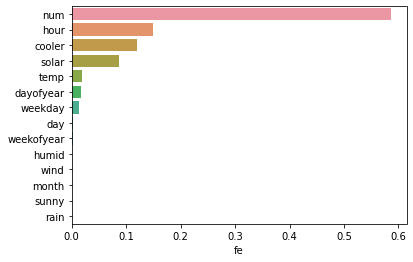

In [66]:
fe_avg = pd.DataFrame(np.mean(fe, axis=0),
                      index=train_building_60.columns, columns=['fe']).sort_values(by=['fe'], ascending=False)
sns.barplot(fe_avg.fe, y=fe_avg.index)
plt.show()

### ETC

In [252]:
# 일주일 전 데이터를 그대로 집어넣는 테스트 서브미션.
answer = []
for i in range(1, 61):
    answer.append(train.loc[train.num == i][-168:]['target'].to_list())

# flatten 해준다.
sub['answer'] = sum(answer, [])

sub.to_csv('submission/210530_test-submission.csv', index=False)
sub

,num_date_time,answer
0,1 2020-08-25 00,8690.976
1,1 2020-08-25 01,8672.184
2,1 2020-08-25 02,8645.616
3,1 2020-08-25 03,8583.408
4,1 2020-08-25 04,8562.672
...,...,...
10075,60 2020-08-31 19,4114.368
10076,60 2020-08-31 20,3975.696
10077,60 2020-08-31 21,3572.208
10078,60 2020-08-31 22,3299.184


6.89 수준이 나온다. 준수한 성능이다.